## Making data masks

This example shows how to make pixel masks using simple expressions.
These masks can be used on the data without assembling detector images,
which is useful as assembly is relatively slow, and reduces accuracy slightly by rounding pixel coordinates.

This example uses AGIPD geometry, but the same technique should work for any supported detector.

In [1]:
%matplotlib inline
import numpy as np
from extra_geom import AGIPD_1MGeometry

<AxesSubplot:title={'center':'AGIPD-1M detector geometry (No file)'}, xlabel='metres', ylabel='metres'>

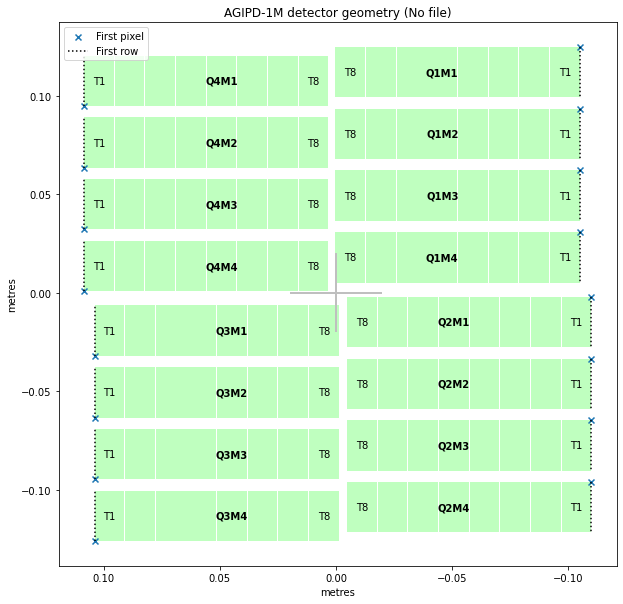

In [2]:
geom = AGIPD_1MGeometry.from_quad_positions(quad_pos=[
    (-525, 625),
    (-550, -10),
    (520, -160),
    (542.5, 475),
])

geom.inspect(axis_units='m')

The [get_pixel_positions()](https://extra-geom.readthedocs.io/en/latest/geometry.html#extra_geom.AGIPD_1MGeometry.get_pixel_positions)
method gives (x, y, z) coordinates for the centre of each pixel.
Here, as is typical, the z coordinates are zero (on the detector plane), so we'll only use x and y.

In [3]:
pixpos = geom.get_pixel_positions()
px, py, pz = np.moveaxis(pixpos, -1, 0)  # Separate x, y, z coordinates
px.shape  # (modules, slow scan, fast scan)

(16, 512, 128)

A rectangular mask is defined by four limits. These numbers are in metres:

In [4]:
rect_mask = (0.01 < px) & (px < 0.05) & (-0.05 < py) & (py < -0.02)

This makes a mask which is true (1) inside the rectangle.
Multiplying `mask * data` will zero out everything outside the selected area.
If you need a mask where 0 indicates pixels to keep, invert it with `~mask`.

By plotting the mask itself like an image, we can see what area it includes.

<AxesSubplot:xlabel='metres', ylabel='metres'>

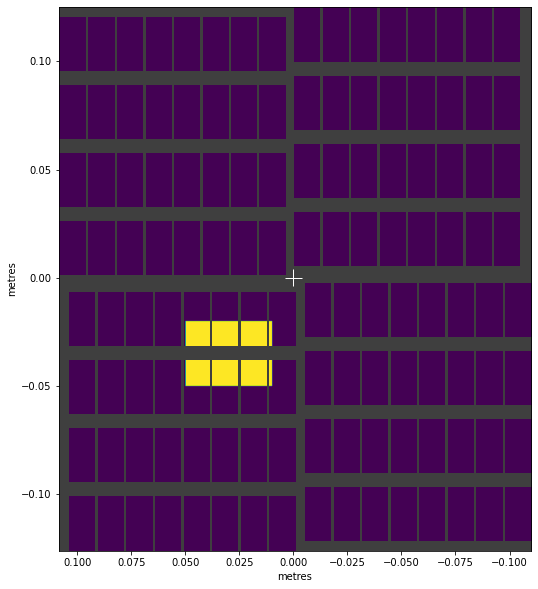

In [5]:
def visualise_mask(mask_arr):
    return geom.plot_data(
        # converting to float allows gaps to be distinguished as NaN.
        mask_arr.astype(float), colorbar=None, axis_units='m'
    )

visualise_mask(rect_mask)

We can make circular shapes by using Pythagoras' theorem to get the distance from the centre to each point ( $c = \sqrt{a^2 + b^2}$ ):

<AxesSubplot:xlabel='metres', ylabel='metres'>

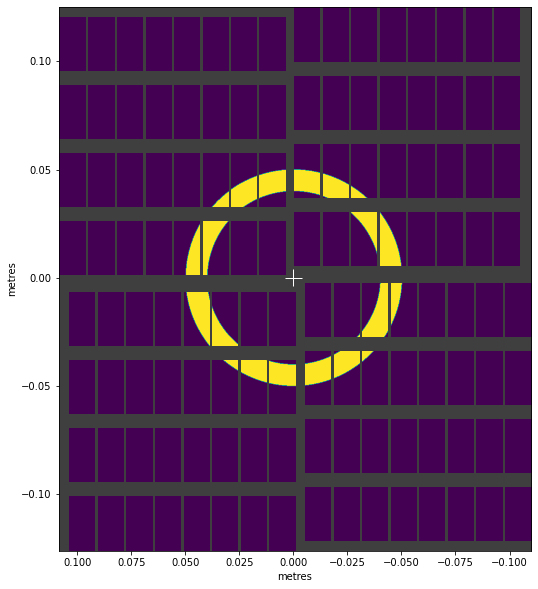

In [6]:
radius = np.sqrt(px**2 + py**2)

ring_mask = (0.04 < radius) & (radius < 0.05)
visualise_mask(ring_mask)

[arctan2()](https://docs.scipy.org/doc/numpy/reference/generated/numpy.arctan2.html) converts x, y coordinates to angles in radians, which enables things like this:

<AxesSubplot:xlabel='metres', ylabel='metres'>

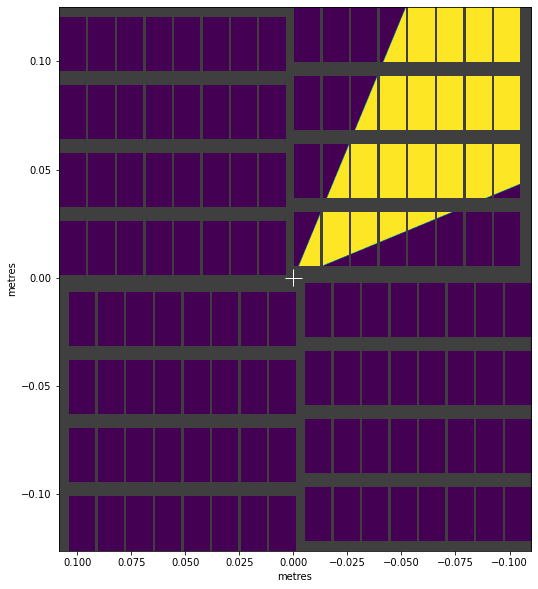

In [7]:
angle = np.arctan2(py, px)

wedge_mask = (np.pi * 5/8 < angle) & (angle < np.pi * 7/8)
visualise_mask(wedge_mask)

We can combine masks with `&` (intersection) and `|` (union) to create more complex shapes:

<AxesSubplot:xlabel='metres', ylabel='metres'>

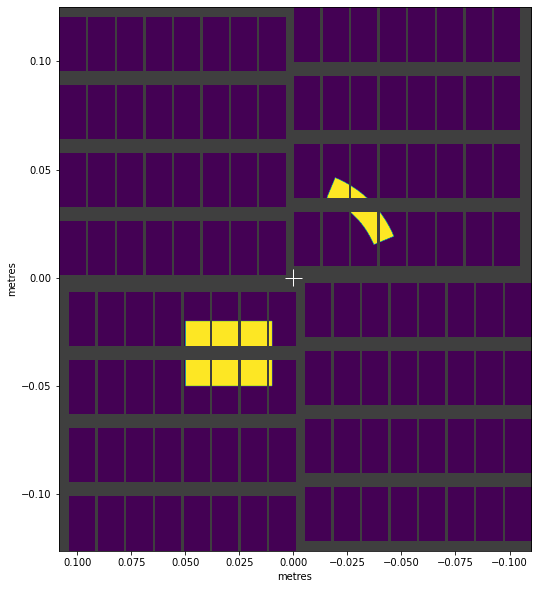

In [8]:
complex_mask = (ring_mask & wedge_mask) | rect_mask
visualise_mask(complex_mask)

This mask only includes data in four detector modules.
If we're selecting that data, we might be able to skip loading the data from the other modules.
We can check which module numbers the mask includes:

In [9]:
modules_included = np.any(complex_mask, axis=(1, 2))
modules_included.nonzero()[0]

array([2, 3, 8, 9])

### Mask AGIPD wide pixels

AGIPD modules contain double width pixels at the boundaries between ASICs. Being larger, these catch more photons, so they can affect results. EXtra-geom contains a function to select them for masking:

In [10]:
from extra_geom import agipd_asic_seams

(0.0, 0.04)

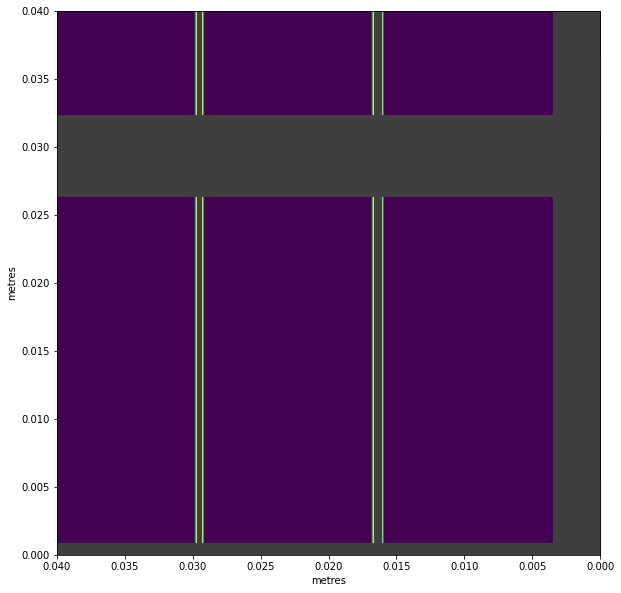

In [11]:
# Get the mask, and repeat it for 16 modules
module_mask = agipd_asic_seams()
all_modules_mask = np.repeat(module_mask[np.newaxis], 16, axis=0)

ax = visualise_mask(all_modules_mask)

# Zoom in to see the masked edges
ax.set_xlim(0.04, 0)
ax.set_ylim(0, 0.04)